In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import numpy as np
from PIL import Image
import torch.utils.data.dataset as datautil


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [2]:
# need to do this twice for it to work for some reason
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Load preprocessed dataset mean and standard deviation 

Text(0.5,1,'Std image')

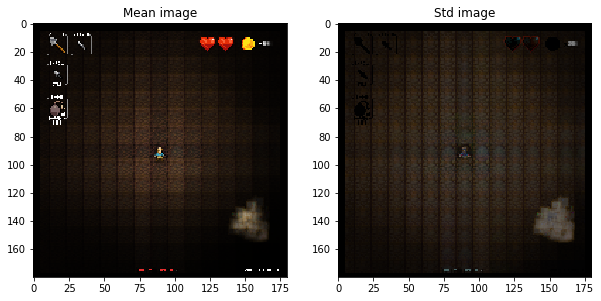

In [3]:
dset_mean = np.load("stats/dsetMean.npy")
dset_std = np.load("stats/dsetStd.npy")

plt.subplot(121)
plt.imshow(np.array(np.round(dset_mean), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(dset_std), dtype=np.uint8))
plt.title("Std image")

Pytorch expects the data shape to be CxHxW (instead of the current HxWxC) so we reshape the mean and std image here, then use them to calculate the means for the three color channels. For images in the training data, this transposition is handled when the dataset object applies the ToTensor() transformation.

In [4]:
dset_mean = np.transpose(dset_mean, (2,0,1))
dset_std = np.transpose(dset_std, (2,0,1))
print(dset_mean.shape, dset_std.shape)

(3, 180, 180) (3, 180, 180)


Finally, calculate the mean and std over the three image channels.

In [5]:
channel_means = dset_mean.mean(axis=(1,2)) / 255
channel_stds = dset_mean.std(axis=(1,2)) / 255 #TODO: just conver to tensor so that you don't have to do this division manually

print("Per-channel means:")
print(channel_means)
print("Per-channel stds:")
print(channel_stds)

Per-channel means:
[0.09893689 0.06650527 0.04448305]
Per-channel stds:
[0.12101782 0.09175113 0.07649331]


# Initialize dataset and data loader objects
Use the channel mean and std to define a normalization transform which our dataset object will apply to each of its images upon loading them.

In [6]:
image_transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize(channel_means, channel_stds)
])

dataset = datasets.DatasetFolder(root='classes/normalized', extensions=['npy'], loader=np.load, transform=image_transform)
# train_dataset = datasets.ImageFolder(root='classes/downscaled', transform=image_transform)
num_train = len(dataset)
print("Training set has {} examples.".format(num_train))

num_val = num_train//10

permutation = np.random.RandomState(seed=0).permutation(num_train)

val_dataset = datautil.Subset(dataset, permutation[:num_val])
train_dataset = datautil.Subset(dataset, permutation[num_val:])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_train-num_val)))

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_val)))

Training set has 2342 examples.


torch.Size([3, 180, 180])
(3, 180, 180)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


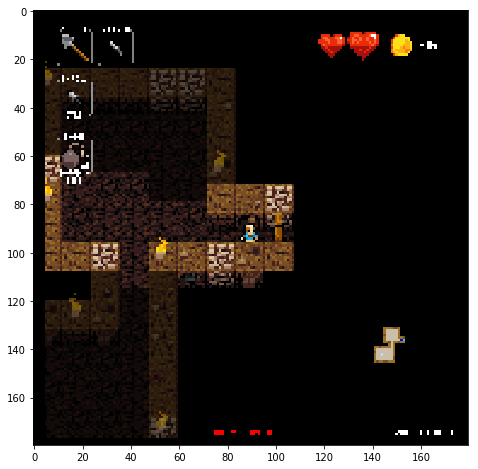

In [7]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images[0].shape)
print(dset_mean.shape)

plt.imshow((images[0].numpy() * dset_std/255 + dset_mean/255).transpose(1,2,0))

# plt.imshow((images[0].numpy() * channel_stds.reshape((3,1,1)) + channel_means.reshape((3,1,1))).transpose(1,2,0))

# Define training and validation functions

In [8]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50000

print('using device:', device)

using device: cuda


In [9]:
def check_model_accuracy(loader, model, name): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('%s set: Got %d / %d correct (%.2f)' % (name, num_correct, num_samples, 100 * acc))
    return acc

In [10]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    train_losses, val_losses = [], []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                train_losses.append(check_model_accuracy(train_loader, model, 'Train'))
                val_losses.append(check_model_accuracy(val_loader, model, 'Val'))
                print()
    return (train_losses, val_losses)

# Load model defined in BCModel.py

In [11]:
from cloningCNN import CloningCNN

model = CloningCNN()


# you can use Nesterov momentum in optim.SGD
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                      momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters())


# Train on the dataset!

In [12]:
train_losses, val_losses = train_model(model, optimizer, epochs=15)

Iteration 0, loss = 1.3829
Train set: Got 784 / 2108 correct (37.19)
Val set: Got 86 / 234 correct (36.75)

Iteration 0, loss = 1.0229
Train set: Got 1198 / 2108 correct (56.83)
Val set: Got 119 / 234 correct (50.85)

Iteration 0, loss = 0.8302
Train set: Got 1462 / 2108 correct (69.35)
Val set: Got 133 / 234 correct (56.84)

Iteration 0, loss = 0.5980
Train set: Got 1620 / 2108 correct (76.85)
Val set: Got 135 / 234 correct (57.69)

Iteration 0, loss = 0.4732
Train set: Got 1742 / 2108 correct (82.64)
Val set: Got 138 / 234 correct (58.97)

Iteration 0, loss = 0.3320
Train set: Got 1855 / 2108 correct (88.00)
Val set: Got 144 / 234 correct (61.54)

Iteration 0, loss = 0.2435
Train set: Got 1953 / 2108 correct (92.65)
Val set: Got 147 / 234 correct (62.82)

Iteration 0, loss = 0.2579
Train set: Got 1995 / 2108 correct (94.64)
Val set: Got 136 / 234 correct (58.12)

Iteration 0, loss = 0.1769
Train set: Got 2040 / 2108 correct (96.77)
Val set: Got 145 / 234 correct (61.97)

Iteration 0,

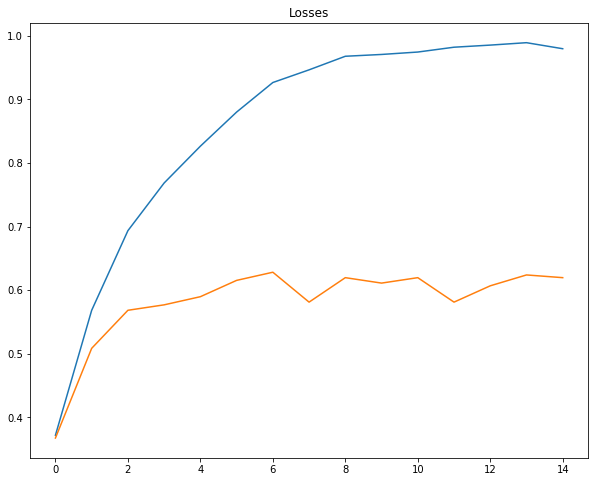

In [13]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Losses")
plt.show()

In [14]:
# ... after training, save your model 
torch.save(model.state_dict(), 'cloningCNN.pt')

In [15]:
model.load_state_dict(torch.load("cloningCNN.pt"))

In [16]:
check_model_accuracy(val_loader, model, 'Val')

Val set: Got 139 / 234 correct (59.40)


0.594017094017094